In [1]:
from wfdb import io, plot
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# Каталог для зберігання даних
d_folder = 'data'
# Спочатку отримуєм список доступних записів пацієнтів
record_names = io.get_record_list('ptbdb')
# І завантажуємо їх у каталог (розкоментуйте цей рядок для завантаження даних) 
# io.dl_database('ptbdb', d_folder, record_names)

# Зчитуємо перший запис
record_name = record_names[0]
record = io.rdrecord(record_name=os.path.join('data', record_name)) 

In [3]:
# формуємо список пацієнтів із необхідними даними для класифікації
records = []
for record_name in tqdm(record_names):
    record = io.rdrecord(record_name=os.path.join('data', record_name))
    # label = comments_to_dict(record.comments)['Reason for admission'][1:]
    label = record.comments[4].split(": ")[-1]
    patient = record_name.split('/')[0]
    signal_length = record.sig_len
    records.append({'name': record_name, 'label': label, 'patient': patient, 'signal_length': signal_length})
     
# записуємо дані в окремий датафрейм для зручності
channels = record.sig_name
df_records = pd.DataFrame(records) 

100%|██████████| 549/549 [00:20<00:00, 23.83it/s]


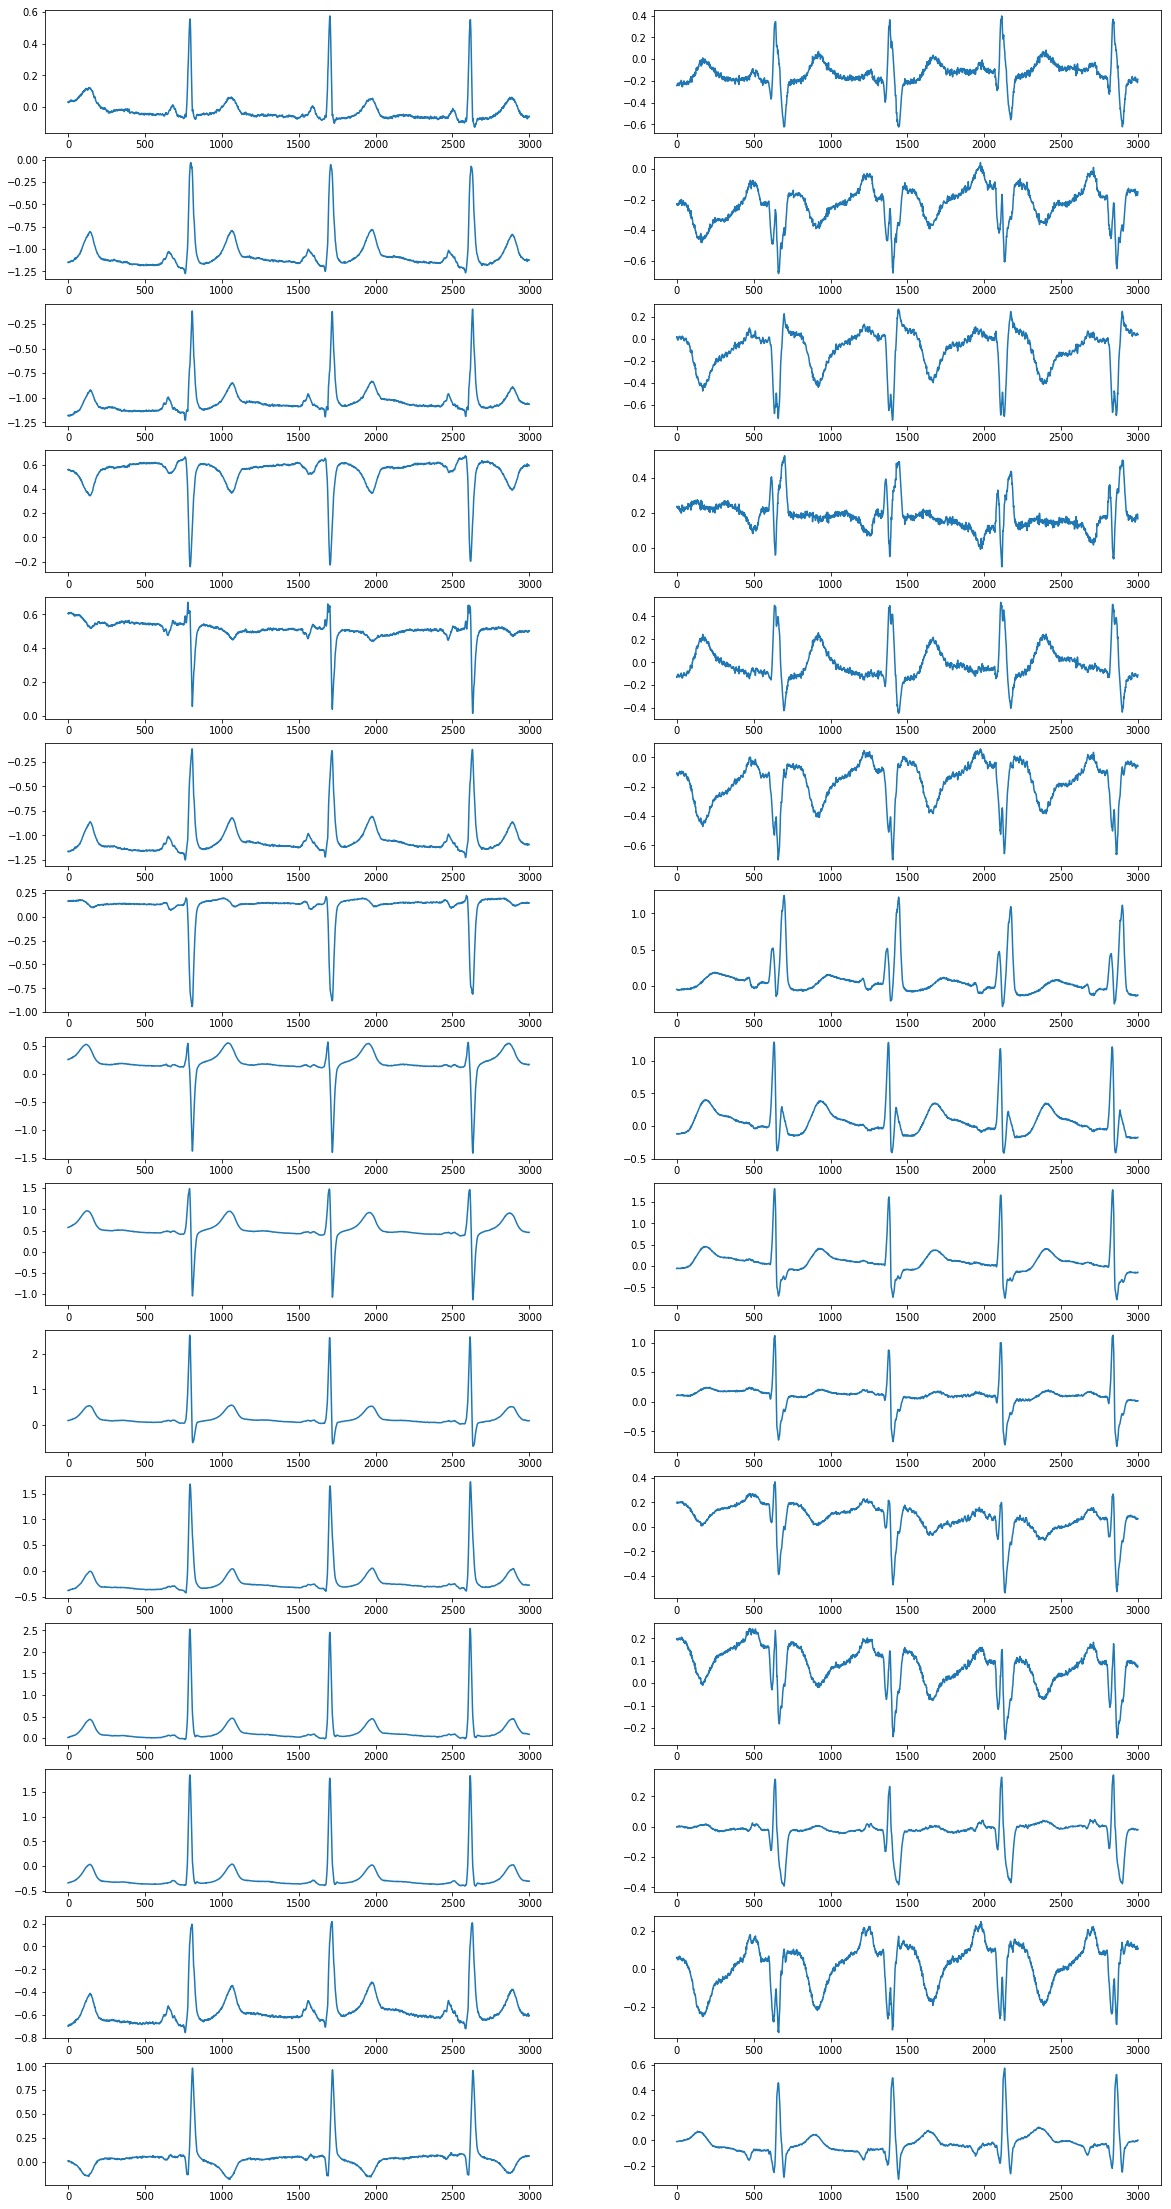

In [4]:
# Шукаємо перший запис здорового пацієнта та пацієнта із інфарктом
control = df_records[df_records['label'] == 'Healthy control'].iloc[0]
infarct = df_records[df_records['label'] == 'Myocardial infarction'].iloc[0]
# Вибираємо із записи дані сигналу кардіограми
control_data = io.rdrecord(record_name=os.path.join('data', control['name'])).p_signal
infarct_data = io.rdrecord(record_name=os.path.join('data', infarct['name'])).p_signal

# Транспонуємо дані для подальшого представлення
control_data = np.transpose(control_data)
infarct_data = np.transpose(infarct_data)

# Виводимо графічне представлення сигналів для порівняння
fig, axes = plt.subplots(15, 2, figsize=(20, 40))
for idx, (control_channel, infarct_channel) in enumerate(zip(control_data, infarct_data)):
    axes[idx][0].plot(control_channel[:3000])
    axes[idx][1].plot(infarct_channel[:3000])

In [5]:
# Створюємо список типів кардіограм, які ми хочемо класифікувати
selected_labels = [
    'Healthy control',
    'Myocardial infarction'
    ]
# Створюємо карту типів для подальшого кодування для нейромережі
label_map = {label: value for label, value in zip(selected_labels, range(len(selected_labels)))}

test_patients = []
train_patients = []
# Ділимо датасет на навчальний та тестовий у співвідношенні 80%/20%
test_size = 0.2
np.random.seed(1337)

# Використовуючи генератор випадкових чисел ділимо датасет
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients += list(np.random.choice(patients, n_test, replace=False))
    train_patients += list(patients[np.isin(patients, test_patients, invert=True)])


def make_set(df_data, label_map, record_id, window_size=2048, n_channels = 15):
    """
    1. Завантажуємо дані кардіограми із датасету
    2. Ділимо довжину даних на розмір вікна (по замовчуванню 2048 - достатньо для трьох ударів серця)
    
    
    Повертаємо:
        dataX: дані кардіограм вписані у вибране вікно (shape = n_windwows, n_channels, window_size)
        dataY: тип кардіограм
        record_list: якщо необхідно - повертаємо назви записів для кожного значення, по замовчуванню - порожній.
    """
    n_windows = 0
    
    for _, record in df_data.iterrows():
        n_windows+= record['signal_length']//window_size

    dataX = np.zeros((n_windows, n_channels, window_size))
    dataY = np.zeros((n_windows, len(label_map)))
    
    record_list = []
    
    nth_window = 0
    for i, (patient, record) in enumerate(df_data.iterrows()):
        # читаємо дані, беремо сигнал і транспонуємо його
        signal_data = io.rdrecord(os.path.join('data', record['name'])).p_signal.transpose()
        n_rows = signal_data.shape[-1]
        n_windows = n_rows//window_size
        dataX[nth_window:nth_window+n_windows] = np.array([signal_data[:,i*window_size:(i+1)*window_size] for i in range(n_windows)])
        dataY[nth_window:nth_window+n_windows][:, label_map[record.label]] = 1
        nth_window+=n_windows
        
        if record_id:
            record_list+= n_windows*[record['name']]
        
    return dataX, dataY, record_list
  

# Встановлюємо назву "пацієнта" як індекс датафрейму, щоб потім простіше витягувати дані 
df_patient_records = df_records.set_index('patient')

# Беремо метадані кожного пацієнта
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[test_patients]
window_size = 2048
trainX, trainY, _ = make_set(df_train_patients, label_map, False, window_size, 15)
testX, testY, record_list = make_set(df_test_patients,label_map, True, window_size, 15)

In [6]:
# Будуємо архітектуру нейромережі і встановлюєм dropout, щоб не було перенавчання
def make_model(input_shape, output_dim, dropout=0.2):
    print("model dim: ", input_shape, output_dim)
    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape, batch_size=None, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(16))
    model.add(Dropout(dropout))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

In [7]:
# Перемішуємо дані, щоб вони йшли у ріному порядку
trainX, trainY = shuffle(trainX, trainY)

# Наступний код потрібно розкоментувати, щоб запустити процес навчання та збереження мережі заново
# Оскільки у нас є імбаланс класів потрібно встановити вагу кожного класу, щоб врівноважити їх
# fractions = 1 - trainY.sum(axis=0) / len(trainY)
# weights = fractions[trainY.argmax(axis=1)]
# 
# # Створюємо нову модель
# model = make_model((trainX.shape[1], trainX.shape[2]), trainY.shape[-1])
# 
# # Запускаємо процес навчання в 50 епох та зберігаємо ваги в окремий файл
# model.fit(trainX, trainY, epochs=50, batch_size=512, sample_weight=weights)
# model.save("ecg-nn.hdf5")

model dim:  (15, 2048) 2
Epoch 1/50
19910/19910 [==============================] - 144s 7ms/step - loss: 0.1984
Epoch 2/50
19910/19910 [==============================] - 58s 3ms/step - loss: 0.1605
Epoch 3/50
19910/19910 [==============================] - 58s 3ms/step - loss: 0.1294
Epoch 4/50
19910/19910 [==============================] - 58s 3ms/step - loss: 0.1069
Epoch 5/50
19910/19910 [==============================] - 58s 3ms/step - loss: 0.0895
Epoch 6/50
19910/19910 [==============================] - 57s 3ms/step - loss: 0.0753
Epoch 7/50
19910/19910 [==============================] - 57s 3ms/step - loss: 0.0638
Epoch 8/50
19910/19910 [==============================] - 58s 3ms/step - loss: 0.0588
Epoch 9/50
19910/19910 [==============================] - 58s 3ms/step - loss: 0.0486
Epoch 10/50
19910/19910 [==============================] - 58s 3ms/step - loss: 0.0457
Epoch 11/50
19910/19910 [==============================] - 58s 3ms/step - loss: 0.0377
Epoch 12/50
19910/19910 [=

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 626  271]
 [ 467 3285]]


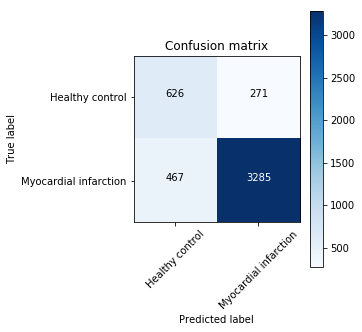

Normalized confusion matrix
[[0.69788183 0.30211817]
 [0.12446695 0.87553305]]


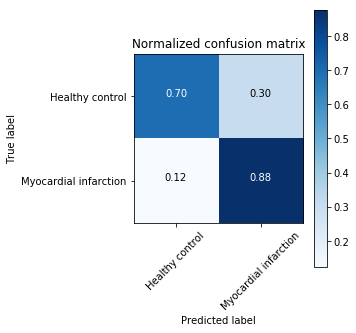

              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77        16
         1.0       0.94      0.96      0.95        67

   micro avg       0.92      0.92      0.92        83
   macro avg       0.87      0.85      0.86        83
weighted avg       0.91      0.92      0.91        83



In [9]:
# Завантажуємо модель з файлу
model = load_model("ecg-nn.hdf5")
# Робимо прогноз класів із тестового датасету для оцінки точності
output = model.predict_classes(testX)
# Будуємо confusion matrix для визначення похибок
conf_matrix = confusion_matrix(testY.argmax(axis=1), output)
class_names = selected_labels

plt.figure(figsize=(5,5))
plot_confusion_matrix(conf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

plt.figure(figsize=(5,5))
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Групуємо послідовності однакового типу і беремо середнє значення для оцінки
# [1,0] - здорова кардіограма, [0,1] - інфаркт. 
# Якщо ми беремо argmax по виходу нейромережі, то отримаємо 0 (здоровий) або 1 (інфаркт) як мітки.
summed = pd.DataFrame({'record':record_list, 'predictions':output, 'label':testY.argmax(axis=1)}).groupby('record').mean()
summed["predicted label"]= summed['predictions'] > 0.5

print(classification_report(summed['label'], summed["predicted label"]))

AUC: 0.787


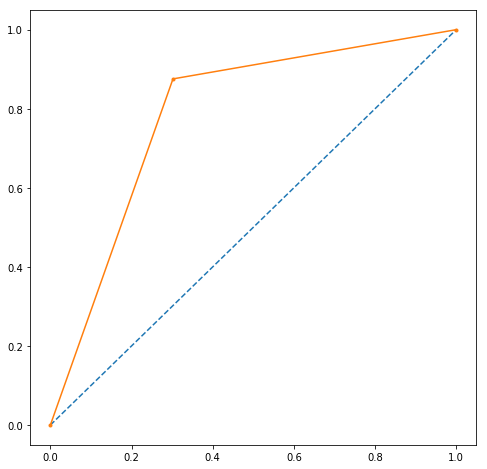

f1=0.899 ||| prec-rec auc=0.950 ||| ap=0.909


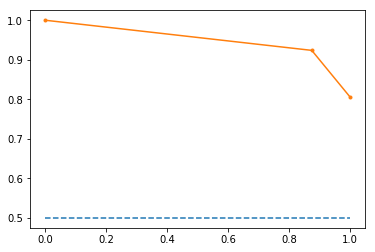

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve,f1_score, auc, average_precision_score
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
auc_val = roc_auc_score(testY.argmax(axis=1), output)
print('AUC: %.3f' % auc_val)
# Розраховуємо roc-криву
fpr, tpr, thresholds = roc_curve(testY.argmax(axis=1), output)
# будуємо лінію рівня 50%
plt.plot([0, 1], [0, 1], linestyle='--')
# будуємо roc-криву
plt.plot(fpr, tpr, marker='.')
plt.show()

precision, recall, thresholds = precision_recall_curve(testY.argmax(axis=1), output)
# рахуємо f1-показник
f1 = f1_score(testY.argmax(axis=1), output)
# рахуємо precision-recall AUC
auc_val = auc(recall, precision)
# рахуємо показник середньої точності
ap = average_precision_score(testY.argmax(axis=1), output)
print('f1=%.3f ||| prec-rec auc=%.3f ||| ap=%.3f' % (f1, auc_val, ap))
# будуємо лінію рівня 50%
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# будуємо roc-криву для моделі
plt.plot(recall, precision, marker='.')
plt.show()